In [1]:
import os
import wandb
import torch
from PIL import Image
from typing import Union
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18 as ResNet

# **Question 1.**

In [2]:
class WildlifeDataset(Dataset):
    root: str
    transform: transforms.Compose|None
    target_transform: transforms.Compose|None
    images: list[str]
    labels: list[str]

    LABEL_TO_INDEX: dict[str, int] = {
        "amur_leopard": 0,
        "amur_tiger": 1,
        "birds": 2,
        "black_bear": 3,
        "brown_bear": 4,
        "dog": 5,
        "roe_deer": 6,
        "sika_deer": 7,
        "wild_boar": 8,
        "people": 9
    }

    INDEX_TO_LABEL: dict[int, str] = {index: label for label, index in LABEL_TO_INDEX.items()}

    def __init__(self, root, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.images = []
        self.labels = []
        for label in WildlifeDataset.LABEL_TO_INDEX.keys():
            label_dir = os.path.join(self.root, label)
            for image in os.listdir(label_dir):
                if image.startswith("augmented"):
                    continue
                self.images.append(os.path.join(label_dir, image))
                self.labels.append(label)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        image = self.images[index]
        label = self.labels[index]
        image = Image.open(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

root = r"Datasets/Russian Wildlife Dataset"
dataset = WildlifeDataset(root, transform=transform, target_transform=WildlifeDataset.LABEL_TO_INDEX.get)

TRAIN, VAL, TEST = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])
TRAIN_LOADER = DataLoader(TRAIN, batch_size=256, shuffle=True)
TEST_LOADER = DataLoader(TEST, batch_size=256, shuffle=True)
VAL_LOADER = DataLoader(VAL, batch_size=256, shuffle=True)

In [4]:
label_counts = {}
total = 0
for i in range(len(dataset)):
    _, l = dataset[i]
    label_counts[l] = label_counts.get(l, 0) + 1
    total += 1
    print(total, label_counts, end="\r")

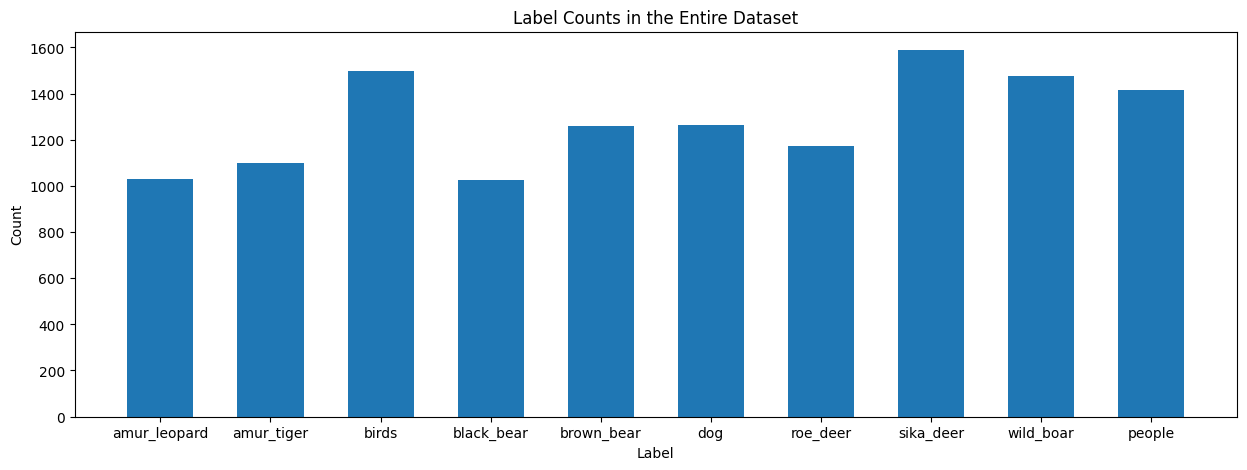

In [5]:
plt.figure(figsize=(15, 5))
plt.bar([WildlifeDataset.INDEX_TO_LABEL.get(key) for key in label_counts.keys()], label_counts.values(), width=0.6)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Counts in the Entire Dataset")
plt.show()

In [6]:
train_label_counts = {}
train_total = 0
for _, label in TRAIN_LOADER:
    for l in label:
        l = WildlifeDataset.INDEX_TO_LABEL.get(l.item())
        train_label_counts[l] = train_label_counts.get(l, 0) + 1
        train_total += 1
        print(train_total, train_label_counts, end="\r")

In [7]:
val_label_counts = {}
val_total = 0
for _, label in VAL_LOADER:
    for l in label:
        l = WildlifeDataset.INDEX_TO_LABEL.get(l.item())
        val_label_counts[l] = val_label_counts.get(l, 0) + 1
        val_total += 1
        print(val_total, val_label_counts, end="\r")

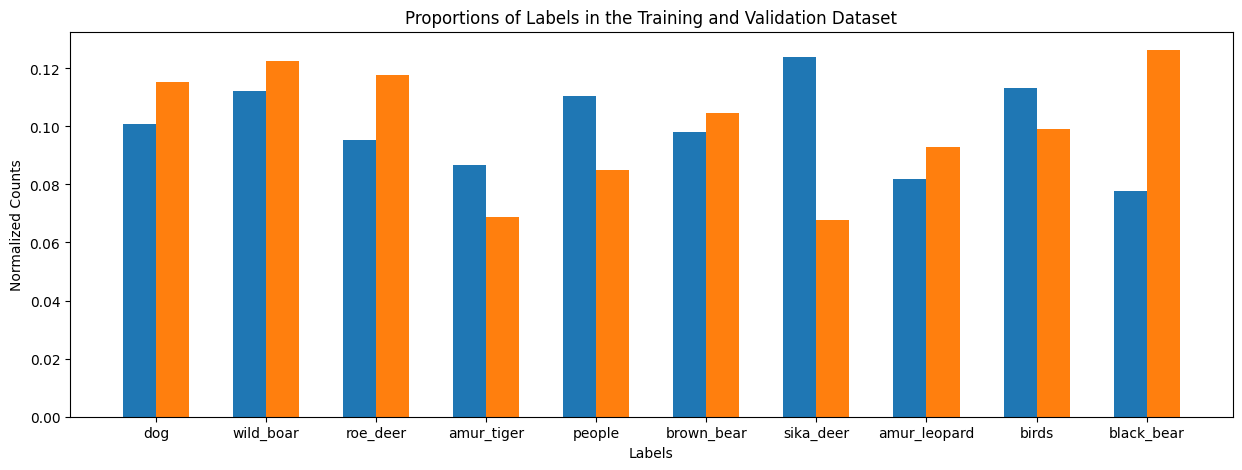

In [8]:
plt.figure(figsize=(15, 5))

train_counts = [count/train_total for count in train_label_counts.values()]
val_counts = [count/val_total for count in val_label_counts.values()]

plt.bar(torch.arange(10) - 0.15, train_counts, width=0.3)
plt.bar(torch.arange(10) + 0.15, val_counts, width=0.3)

plt.xticks(torch.arange(10), train_label_counts.keys())
plt.xlabel("Labels")
plt.ylabel("Normalized Counts")

plt.title("Proportions of Labels in the Training and Validation Dataset")
plt.show()

In [9]:
# wandb.init(project="russian-wildlife")
# We use the in built Python Context Manager for this

# **Question 2.**

In [4]:
class ConvNet(torch.nn.Module):
    def __init__(self, config: dict[str, float|str]):
        super(ConvNet, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=4)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = torch.nn.Linear(128*16*16, config["CLASSES"])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [21]:
def pipeline(hyperparams: dict[str, float|str]) -> dict[str, Union[ConvNet, ResNet, tuple[DataLoader]]]:
    with wandb.init(project="russian-wildlife", config=hyperparams):
        config = wandb.config
        print("Initializing Architecture")
        if config.ARCHITECTURE == "ConvNet":
            model = ConvNet(config)
        else:
            model = ResNet(pretrained=True)
            model.fc = torch.nn.Linear(model.fc.in_features, config.CLASSES)
        train_loader, test_loader, val_loader = load_data(config)
        train(model, config, train_loader, val_loader)
        test(model, test_loader)
        torch.save(model.state_dict(), f"{config.ARCHITECTURE}.pth")
    return {"model": model, "data": (train_loader, test_loader, val_loader)}


def load_data(config: dict[str, float|str]) -> tuple[DataLoader]:
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    print("Loading Dataset")
    root = rf"Datasets/{config.DATASET} Dataset"
    dataset = WildlifeDataset(root, transform=transform, target_transform=WildlifeDataset.LABEL_TO_INDEX.get)

    if config.AUGMENT:
        print("Augmenting")
        augment = transforms.Compose([
            transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)
        ])

        augmented = 0
        for index in torch.randperm(len(dataset))[:2000]:
            augmented += 1
            image = dataset.images[index]
            label = dataset.labels[index]
            augmented_image = augment(Image.open(image))
            path = os.path.join(root, os.path.join(label, f"augmented-{augmented}.jpg"))
            augmented_image.save(path)
            dataset.images.append(path)
            dataset.labels.append(label)

        print(f"Augmented {augmented} images")

    print("Splitting Datasets")
    train, test, val = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])
    train_loader = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val, batch_size=config.BATCH_SIZE, shuffle=True)
    return train_loader, test_loader, val_loader

def train(model: Union[ConvNet, ResNet], config: dict[str, float|str], train_loader: DataLoader, val_loader: DataLoader) -> None:
    print("Initializing Training")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)
    wandb.watch(model, criterion, log="all", log_freq=5)

    for epoch in tqdm(range(1, config.EPOCHS+1)):
        model.train()
        total_loss = correct = total = 0
        for images, labels in train_loader:
            outputs = model(images)
            total_loss += (loss := criterion(outputs, labels)).item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.shape[0]
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss, train_acc = total_loss/total, correct/total
        print(f"Training: Epoch [{epoch}/{config.EPOCHS}] | Loss: {train_loss:.10f} | Accuracy: {train_acc:.10f}")

        model.eval()
        with torch.no_grad():
            total_loss = correct = total = 0
            for images, labels in val_loader:
                outputs = model(images)
                total_loss += (loss := criterion(outputs, labels)).item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.shape[0]
            val_loss, val_acc = total_loss/total, correct/total
        print(f"Validating: Epoch [{epoch}/{config.EPOCHS}] | Loss: {val_loss:.10f} | Accuracy: {val_acc:.10f}")

        wandb.log({
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_acc
        }, step=epoch)

    print("Training Complete")


def test(model: Union[ConvNet, ResNet], test_loader: DataLoader) -> None:
    model.eval()
    LABELS, OUTPUTS = torch.tensor([]), torch.tensor([])

    with torch.no_grad():
        TP = torch.zeros(10)
        TN = torch.zeros(10)
        FP = torch.zeros(10)
        FN = torch.zeros(10)
        for i, (images, labels) in enumerate(test_loader, start=1):
            try:
                outputs = model(images).argmax(1)
            except AttributeError:
                pass
            else:
                LABELS = torch.cat([LABELS, labels])
                OUTPUTS = torch.cat([OUTPUTS, outputs])
                for i in range(10):
                    TP[i] += ((outputs == i) & (labels == i)).sum()
                    TN[i] += ((outputs != i) & (labels != i)).sum()
                    FP[i] += ((outputs == i) & (labels != i)).sum()
                    FN[i] += ((outputs != i) & (labels == i)).sum()
                print(f"Testing: Batch [{i}/{len(test_loader)}]", end="\r")

    TP, TN, FP, FN = TP.sum(), TN.sum(), FP.sum(), FN.sum()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            y_true=LABELS.int().tolist(), preds=OUTPUTS.int().tolist(),
            class_names=list(WildlifeDataset.LABEL_TO_INDEX.keys())
        )
    })

    print(f"Accuracy: {accuracy:.10f} | Precision: {precision:.10f} | Recall: {recall:.10f} | F1 Score: {f1:.10f}")

In [10]:
CONFIG = dict(
    LR=0.001,
    EPOCHS=15,
    CLASSES=10,
    AUGMENT=False,
    BATCH_SIZE=256,
    ARCHITECTURE="ConvNet",
    DATASET="Russian Wildlife"
)
convnet_run = pipeline(CONFIG)
convnet = convnet_run["model"]
train_loader, test_loader, val_loader = convnet_run["data"]

Initializing Architecture
Loading Dataset
Splitting Datasets
Initializing Training


  0%|          | 0/15 [00:00<?, ?it/s]

Training: Epoch [1/15] | Loss: 0.0083154323 | Accuracy: 0.2406994876
Validating: Epoch [1/15] | Loss: 0.0081738308 | Accuracy: 0.2792511700
Training: Epoch [2/15] | Loss: 0.0070795015 | Accuracy: 0.3854978837
Validating: Epoch [2/15] | Loss: 0.0074478724 | Accuracy: 0.3861154446
Training: Epoch [3/15] | Loss: 0.0062869735 | Accuracy: 0.4721541546
Validating: Epoch [3/15] | Loss: 0.0062252226 | Accuracy: 0.4929797192
Training: Epoch [4/15] | Loss: 0.0056589093 | Accuracy: 0.5297393629
Validating: Epoch [4/15] | Loss: 0.0076569915 | Accuracy: 0.4898595944
Training: Epoch [5/15] | Loss: 0.0051930117 | Accuracy: 0.5746268657
Validating: Epoch [5/15] | Loss: 0.0073114366 | Accuracy: 0.5257410296
Training: Epoch [6/15] | Loss: 0.0048138221 | Accuracy: 0.6003564268
Validating: Epoch [6/15] | Loss: 0.0068052331 | Accuracy: 0.5686427457
Training: Epoch [7/15] | Loss: 0.0042370015 | Accuracy: 0.6524838494
Validating: Epoch [7/15] | Loss: 0.0057009095 | Accuracy: 0.5608424337
Training: Epoch [8/1

The details of the above model (LAMBENT-LANTERN-35) can be found at:
- This Project:  https://wandb.ai/whatwhat/russian-wildlife
- This Run: https://wandb.ai/whatwhat/russian-wildlife/runs/mlk5555o
- Logs: .\wandb\run-20240218_120407-mlk5555o\logs

In [10]:
MISCLASSIFIED = {label: [] for label in WildlifeDataset.LABEL_TO_INDEX.keys()}
convnet.eval()

with torch.no_grad():
    counter = 0
    for images, labels in test_loader:
        try:
            outputs = convnet(images).argmax(1)
        except AttributeError:
            continue
        for image, label, output in zip(images, labels, outputs):
            label = WildlifeDataset.INDEX_TO_LABEL.get(label.item())
            output = WildlifeDataset.INDEX_TO_LABEL.get(output.item())
            if label != output and len(MISCLASSIFIED[label]) < 3:
                MISCLASSIFIED[label].append((image, output))
                counter += 1
    print(f"Found {counter} misclassified images")

Found 30 misclassified images


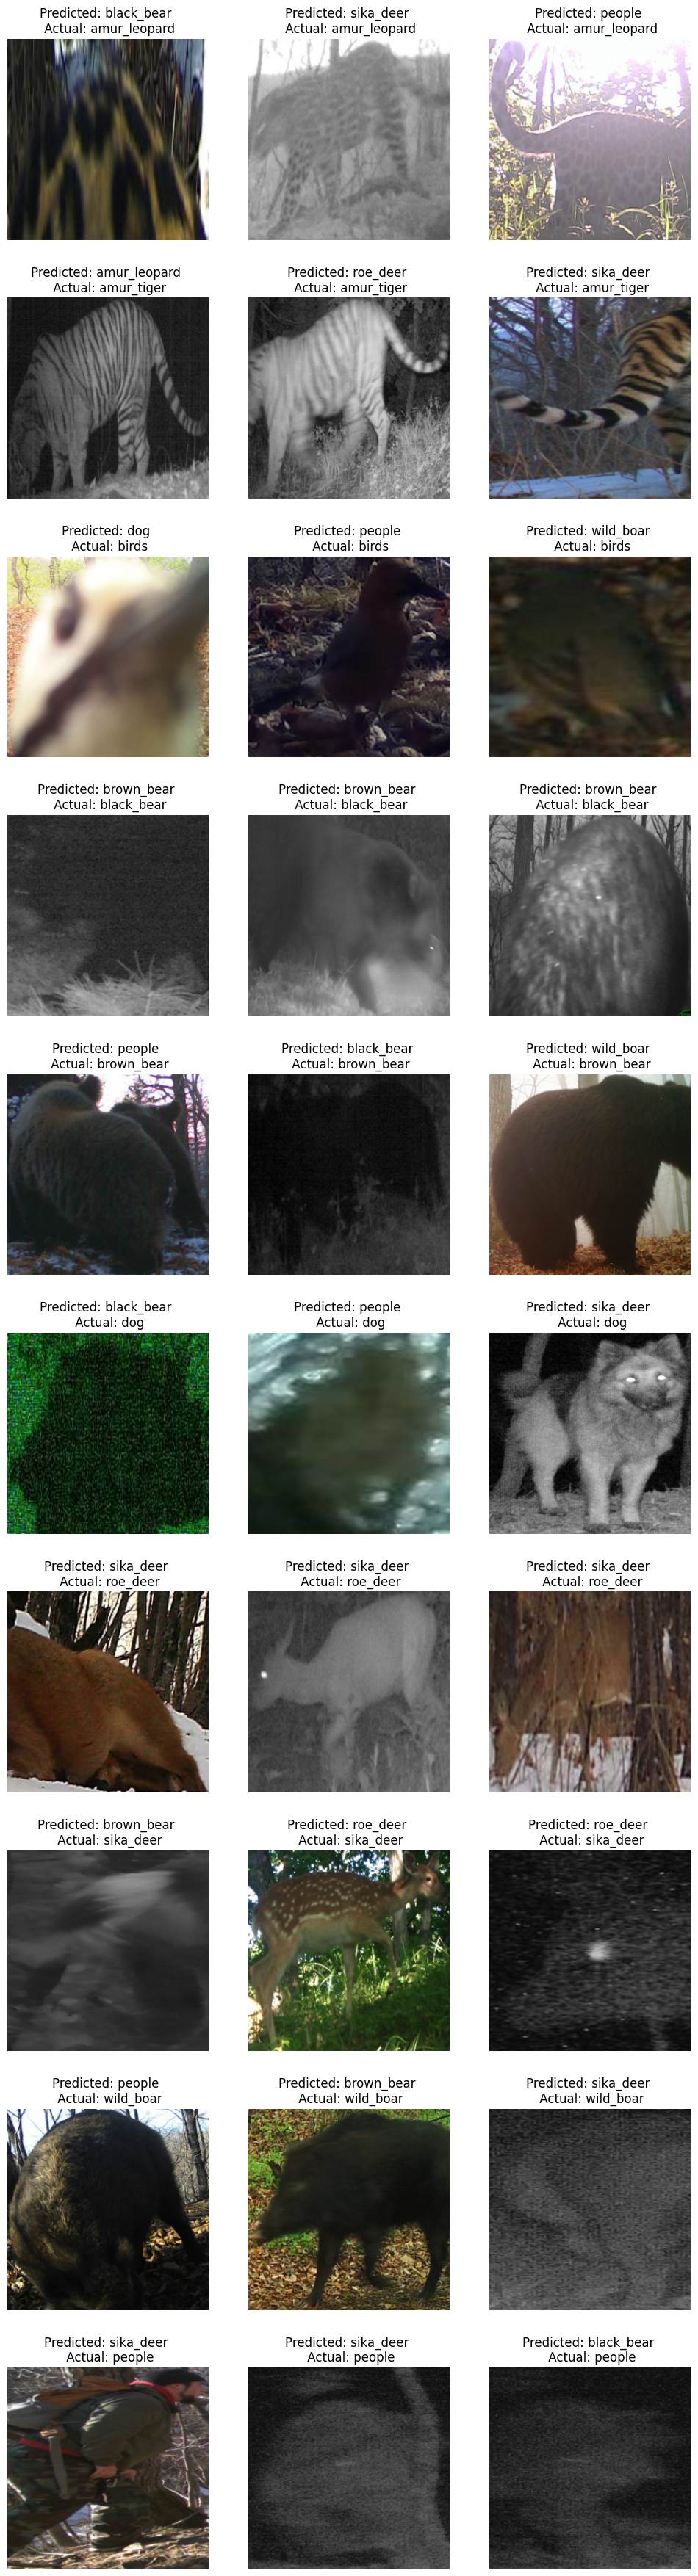

In [64]:
fig, axes = plt.subplots(10, 3, figsize=(12, 45))
for i, (label, images) in enumerate(MISCLASSIFIED.items()):
    for j, (image, output) in enumerate(images):
        axes[i, j].imshow(image.permute(1, 2, 0))
        axes[i, j].set_title(f"Predicted: {output} \n Actual: {label}")
        axes[i, j].axis("off")
plt.show()

# **Question 3.**

In [22]:
CONFIG = dict(
    LR=0.001,
    EPOCHS=10,
    CLASSES=10,
    AUGMENT=False,
    BATCH_SIZE=256,
    ARCHITECTURE="ResNet",
    DATASET="Russian Wildlife"
)

resnet_run = pipeline(CONFIG)
resnet = resnet_run["model"]
train_loader, test_loader, val_loader = resnet_run["data"]

Initializing Architecture
Loading Dataset
Splitting Datasets
Initializing Training


  0%|          | 0/10 [00:00<?, ?it/s]

Training: Epoch [1/10] | Loss: 0.0030139579 | Accuracy: 0.7394742704
Validating: Epoch [1/10] | Loss: 0.0066443391 | Accuracy: 0.6099843994
Training: Epoch [2/10] | Loss: 0.0016534124 | Accuracy: 0.8572065048
Validating: Epoch [2/10] | Loss: 0.0028061128 | Accuracy: 0.8088923557
Training: Epoch [3/10] | Loss: 0.0009360413 | Accuracy: 0.9234796168
Validating: Epoch [3/10] | Loss: 0.0023559902 | Accuracy: 0.8268330733
Training: Epoch [4/10] | Loss: 0.0007095579 | Accuracy: 0.9421920249
Validating: Epoch [4/10] | Loss: 0.0032576738 | Accuracy: 0.7706708268
Training: Epoch [5/10] | Loss: 0.0007628016 | Accuracy: 0.9390732903
Validating: Epoch [5/10] | Loss: 0.0037071020 | Accuracy: 0.7854914197
Training: Epoch [6/10] | Loss: 0.0008351401 | Accuracy: 0.9290487859
Validating: Epoch [6/10] | Loss: 0.0031399103 | Accuracy: 0.8026521061
Training: Epoch [7/10] | Loss: 0.0006549006 | Accuracy: 0.9529962130
Validating: Epoch [7/10] | Loss: 0.0080715184 | Accuracy: 0.6388455538
Training: Epoch [8/1

The details of the above model (CHEERFUL-PAPER-42) can be found at:
- This Project:  https://wandb.ai/whatwhat/russian-wildlife
- This Run: https://wandb.ai/whatwhat/russian-wildlife/runs/e1jiempk
- Logs: .\wandb\run-20240218_152911-e1jiempk\logs

In [26]:
resnet_feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet_feature_extractor.eval()

with torch.no_grad():
    tsne = TSNE(n_components=2, random_state=0)
    print("Computing 2D-TSNE for Training Data")
    images, labels = next(iter(train_loader))
    train_embedding = tsne.fit_transform(resnet_feature_extractor(images).reshape(images.shape[0], -1))
    print("Computing 2D-TSNE for Validation Data")
    images, labels = next(iter(val_loader))
    val_embedding = tsne.fit_transform(resnet_feature_extractor(images).reshape(images.shape[0], -1))

Computing 2D-TSNE for Training Data
Computing 2D-TSNE for Validation Data


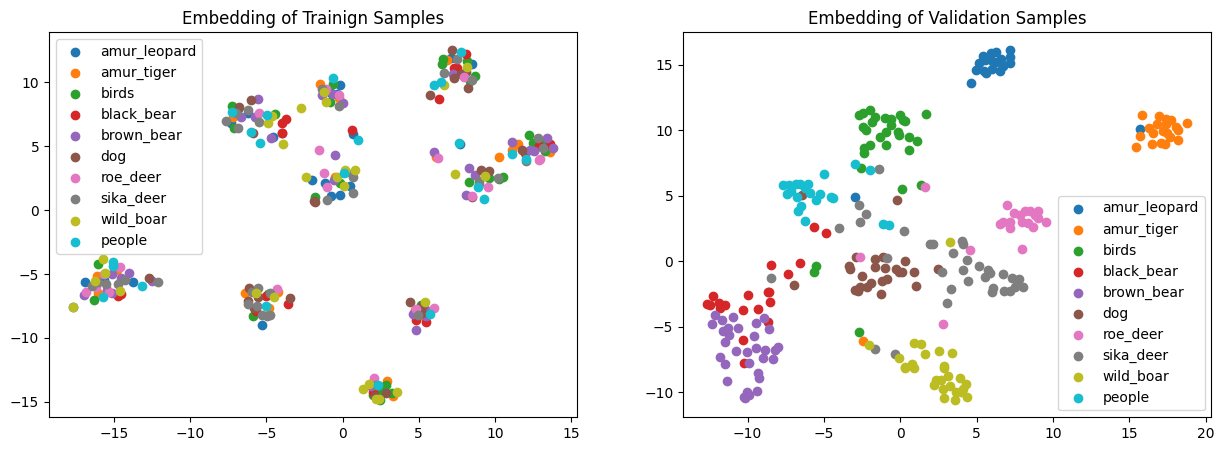

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Embedding of Trainign Samples")
for label in WildlifeDataset.LABEL_TO_INDEX.keys():
    indices = labels == WildlifeDataset.LABEL_TO_INDEX.get(label)
    plt.scatter(train_embedding[indices, 0], train_embedding[indices, 1], label=label, marker="o")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Embedding of Validation Samples")
for label in WildlifeDataset.LABEL_TO_INDEX.keys():
    indices = labels == WildlifeDataset.LABEL_TO_INDEX.get(label)
    plt.scatter(val_embedding[indices, 0], val_embedding[indices, 1], label=label, marker="o")
plt.legend()

In [31]:
images, labels = torch.tensor([]), torch.tensor([])
for image, label in val_loader:
    images = torch.cat([images, image])
    labels = torch.cat([labels, label])

with torch.no_grad():
    print("Computing 3D-TSNE for Validation Data")
    tsne = TSNE(n_components=3, random_state=0)
    embedding = tsne.fit_transform(resnet_feature_extractor(images).reshape(images.shape[0], -1))

Computing 3D-TSNE for Validation Data


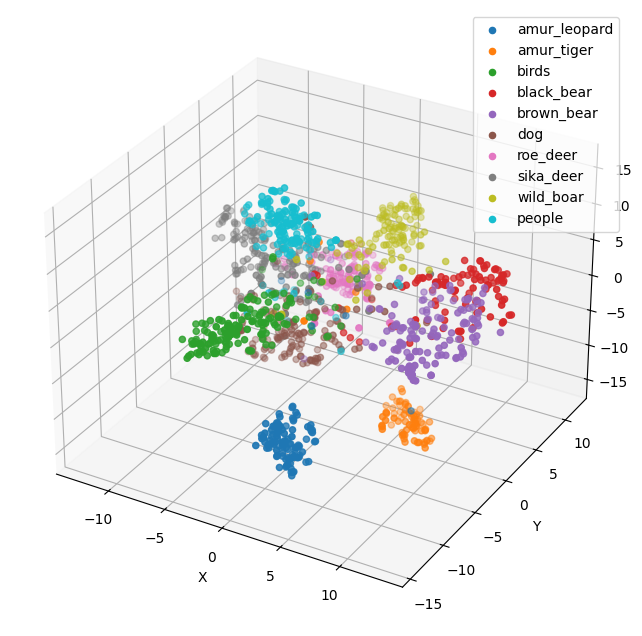

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

for label in WildlifeDataset.LABEL_TO_INDEX.keys():
    indices = labels == WildlifeDataset.LABEL_TO_INDEX.get(label)
    ax.scatter(embedding[indices, 0], embedding[indices, 1], embedding[indices, 2], label=label)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

In [33]:
CONFIG = dict(
    LR=0.001,
    EPOCHS=10,
    CLASSES=10,
    AUGMENT=True,
    BATCH_SIZE=256,
    ARCHITECTURE="ResNet-Aug",
    DATASET="Russian Wildlife"
)

resnet_aug_run = pipeline(CONFIG)
resnet_aug = resnet_aug_run["model"]
train_loader, test_loader, val_loader = resnet_aug_run["data"]

Initializing Architecture


c:\Users\Divyajeet Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Divyajeet Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading Dataset
Augmenting
Augmented 2000 images
Splitting Datasets
Initializing Training


  0%|          | 0/10 [00:00<?, ?it/s]

Training: Epoch [1/10] | Loss: 0.0028762342 | Accuracy: 0.7475428792
Validating: Epoch [1/10] | Loss: 0.0029239652 | Accuracy: 0.7388663968
Training: Epoch [2/10] | Loss: 0.0014023423 | Accuracy: 0.8806128348
Validating: Epoch [2/10] | Loss: 0.0034190739 | Accuracy: 0.7483130904
Training: Epoch [3/10] | Loss: 0.0009292337 | Accuracy: 0.9215648487
Validating: Epoch [3/10] | Loss: 0.0021700767 | Accuracy: 0.8191632928
Training: Epoch [4/10] | Loss: 0.0006770407 | Accuracy: 0.9428598959
Validating: Epoch [4/10] | Loss: 0.0031834015 | Accuracy: 0.7692307692
Training: Epoch [5/10] | Loss: 0.0005614760 | Accuracy: 0.9527847369
Validating: Epoch [5/10] | Loss: 0.0029518169 | Accuracy: 0.7860998650
Training: Epoch [6/10] | Loss: 0.0003550511 | Accuracy: 0.9711890538
Validating: Epoch [6/10] | Loss: 0.0019607849 | Accuracy: 0.8542510121
Training: Epoch [7/10] | Loss: 0.0001915208 | Accuracy: 0.9846791289
Validating: Epoch [7/10] | Loss: 0.0017998203 | Accuracy: 0.8711201080
Training: Epoch [8/1

The details of the above model (VERMILION-PAPER-43) can be found at:
- This Project:  https://wandb.ai/whatwhat/russian-wildlife
- This Run: https://wandb.ai/whatwhat/russian-wildlife/runs/7oi0grju
- Logs: .\wandb\run-20240218_190912-7oi0grju\logs

In [41]:
convnet_feature_extractor = torch.nn.Sequential(*list(convnet.children())[:-1], torch.nn.Flatten())
convnet_feature_extractor.eval()

resnet_feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet_feature_extractor.eval()

resnet_aug_feature_extractor = torch.nn.Sequential(*list(resnet_aug.children())[:-1])
resnet_aug_feature_extractor.eval()

convnet_centroids = torch.zeros(10, 128*16*16)
resnet_centroids = torch.zeros(10, 512)
resnet_aug_centroids = torch.zeros(10, 512)
label_counts = torch.zeros(10)

print("Computing Centroids")
with torch.no_grad():
    counter = 0
    for images, labels in train_loader:
        convnet_features = convnet_feature_extractor(images)
        resnet_features = resnet_feature_extractor(images)
        resnet_aug_features = resnet_aug_feature_extractor(images)
        counter += convnet_features.shape[0]
        print("Counted", counter, "samples", end="\r")
        for convnet_feature, resnet_feature, resnet_aug_feature, label in zip(convnet_features, resnet_features, resnet_aug_features, labels):
            convnet_centroids[label] += convnet_feature
            resnet_centroids[label] += resnet_feature.flatten()
            resnet_aug_centroids[label] += resnet_aug_feature.flatten()
            label_counts[label] += 1
    convnet_centroids /= label_counts[:, None]
    resnet_centroids /= label_counts[:, None]
    resnet_aug_centroids /= label_counts[:, None]

print()
print("Computed Centroids")

Computing Centroids
Counted 10378 samples
Computed Centroids


In [69]:
convnet_last_layer = torch.nn.Sequential(list(convnet.children())[-1])
resnet_last_layer = torch.nn.Sequential(list(resnet.children())[-1])
resnet_aug_last_layer = torch.nn.Sequential(list(resnet_aug.children())[-1])

In [83]:
convnet_distances = torch.zeros(10, 3, 2, dtype=torch.float32)
resnet_distances = torch.zeros(10, 3, 2, dtype=torch.float32)
resnet_aug_distances = torch.zeros(10, 3, 2, dtype=torch.float32)

predictions = {}

for i, (label, images) in enumerate(MISCLASSIFIED.items()):
    actual = WildlifeDataset.LABEL_TO_INDEX.get(label)
    predictions[actual] = []
    for j, (image, output) in enumerate(images):
        predicted = WildlifeDataset.LABEL_TO_INDEX.get(output)
        with torch.no_grad():
            convnet_features = convnet_feature_extractor(image.unsqueeze(0))
            convnet_pred = convnet_last_layer(convnet_features).argmax(1).item()
            convnet_distances[actual, j, 0] = torch.norm(convnet_features - convnet_centroids[actual])
            convnet_distances[actual, j, 1] = torch.norm(convnet_features - convnet_centroids[convnet_pred])

            resnet_features = resnet_feature_extractor(image.unsqueeze(0))
            resnet_pred = resnet_last_layer(resnet_features.reshape(1, 512)).argmax(1).item()
            resnet_distances[actual, j, 0] = torch.norm(resnet_features - resnet_centroids[actual])
            resnet_distances[actual, j, 1] = torch.norm(resnet_features - resnet_centroids[resnet_pred])

            resnet_aug_features = resnet_aug_feature_extractor(image.unsqueeze(0))
            resnet_aug_pred = resnet_aug_last_layer(resnet_aug_features.reshape(1, 512)).argmax(1).item()
            resnet_aug_distances[actual, j, 0] = torch.norm(resnet_aug_features - resnet_aug_centroids[actual])
            resnet_aug_distances[actual, j, 1] = torch.norm(resnet_aug_features - resnet_aug_centroids[resnet_aug_pred])

            predictions[actual].append((convnet_pred, resnet_pred, resnet_aug_pred))

        print(f"Computed Distances for {label}: [{j+1}/3]", end="\r")

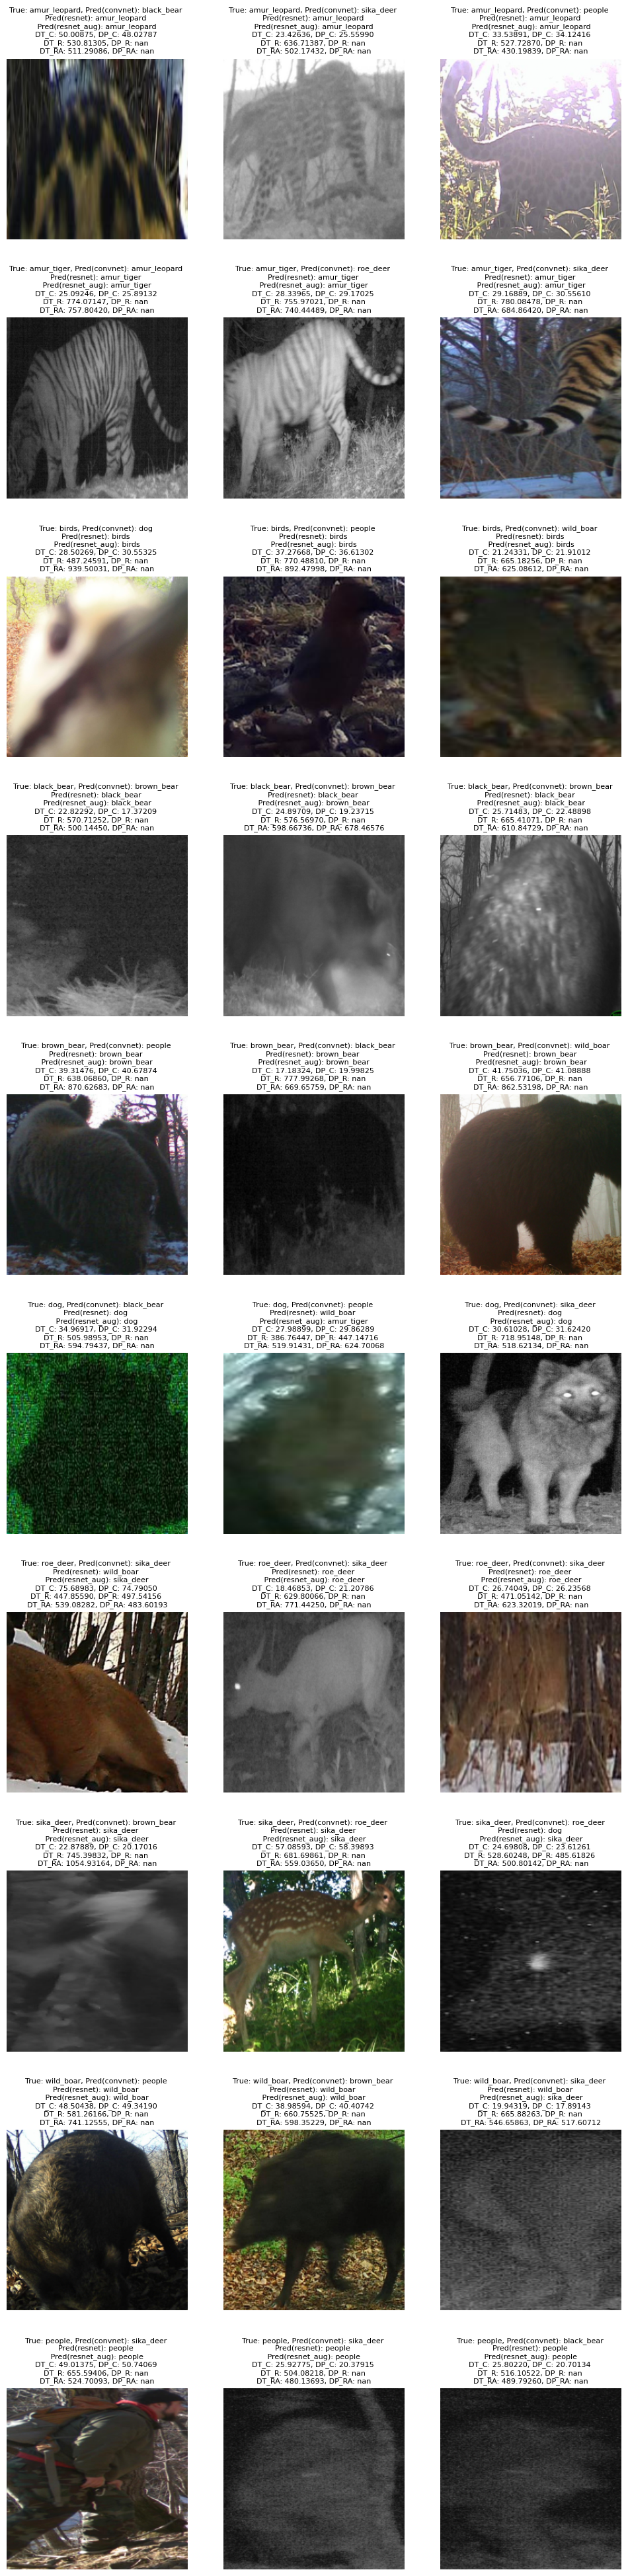

In [85]:
fig, axes = plt.subplots(10, 3, figsize=(12, 50))
for i, (label, images) in enumerate(MISCLASSIFIED.items()):
    actual = WildlifeDataset.LABEL_TO_INDEX.get(label)
    for j, (image, output) in enumerate(images):
        _, resnet_output, resnet_aug_output = predictions[actual][j]
        resnet_output = WildlifeDataset.INDEX_TO_LABEL.get(resnet_output)
        resnet_aug_output = WildlifeDataset.INDEX_TO_LABEL.get(resnet_aug_output)
        if resnet_output == label:
            resnet_distances[actual, j, 1] = torch.nan
        if resnet_aug_output == label:
            resnet_aug_distances[actual, j, 1] = torch.nan
        axes[i, j].imshow(image.permute(1, 2, 0))
        axes[i, j].set_title(
            f"True: {label}, Pred(convnet): {output} \n"
            f"Pred(resnet): {resnet_output} \n Pred(resnet_aug): {resnet_aug_output} \n"
            f"DT_C: {convnet_distances[actual, j, 0]:.5f}, DP_C: {convnet_distances[actual, j, 1]:.5f} \n"
            f"DT_R: {resnet_distances[actual, j, 0]:.5f}, DP_R: {resnet_distances[actual, j, 1]:.5f} \n"
            f"DT_RA: {resnet_aug_distances[actual, j, 0]:.5f}, DP_RA: {resnet_aug_distances[actual, j, 1]:.5f}",
            fontsize=8
        )
        axes[i, j].axis("off")
plt.show()